In [1]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


---
# Policy Gradient
---
### Policy-based methods predict actions directly.

E.g. 

Value-based: $S \times A \rightarrow Q$

Policy-based: $S \rightarrow A$

In [3]:
def discount_and_norm_rewards(r, gamma, norm=True):
        dnr = np.zeros_like(r)
        cumulative = 0
        for t in reversed(range(len(r))):
            cumulative = cumulative * gamma + r[t]
            dnr[t] = cumulative
        if norm:
            dnr -= np.mean(dnr)
            dnr /= np.std(dnr)
        return dnr

In [4]:
# Sample sequence
env.reset()
s_hist, a_hist, r_hist = [], [], []
while True:
    a = env.action_space.sample()
    s, r, d, _ = env.step(a)

    s_hist.append(s)
    a_hist.append(a)
    r_hist.append(r)

    if d:
        break
    
print("State / Action / Reward")
list(zip(s_hist, a_hist, r_hist))

State / Action / Reward


[(array([ 0.02275145, -0.2287418 , -0.01490167,  0.29688753]), 0, 1.0),
 (array([ 0.01817661, -0.03341062, -0.00896392, -0.00045764]), 1, 1.0),
 (array([ 0.0175084 ,  0.16183873, -0.00897308, -0.29595526]), 1, 1.0),
 (array([ 0.02074518, -0.03315416, -0.01489218, -0.00611575]), 0, 1.0),
 (array([ 0.02008209,  0.16217816, -0.0150145 , -0.30345988]), 1, 1.0),
 (array([ 0.02332566,  0.35751084, -0.02108369, -0.60083997]), 1, 1.0),
 (array([ 0.03047587,  0.55292129, -0.03310049, -0.90008865]), 1, 1.0),
 (array([ 0.0415343 ,  0.74847578, -0.05110227, -1.20298947]), 1, 1.0),
 (array([ 0.05650381,  0.94421985, -0.07516206, -1.5112398 ]), 1, 1.0),
 (array([ 0.07538821,  1.14016752, -0.10538685, -1.82640831]), 1, 1.0),
 (array([ 0.09819156,  1.33628858, -0.14191502, -2.14988418]), 1, 1.0),
 (array([ 0.12491733,  1.14282009, -0.1849127 , -1.90418197]), 0, 1.0),
 (array([ 0.14777373,  0.95011627, -0.22299634, -1.67410903]), 0, 1.0)]

In [5]:
discount_and_norm_rewards(r_hist, .9, 0)

array([7.45813417, 7.17570464, 6.86189404, 6.5132156 , 6.12579511,
       5.6953279 , 5.217031  , 4.68559   , 4.0951    , 3.439     ,
       2.71      , 1.9       , 1.        ])

In [6]:
tf.reset_default_graph()
#--------------------------------
# Neural Network as function approximator (replace Q table)
#--------------------------------

# environment dimensions
s_shape = env.observation_space.shape[0]
a_shape = env.action_space.n

# input placeholders
S = tf.placeholder(tf.float32,[None, s_shape],name='state_input')
actions = tf.placeholder(tf.int32, [None, a_shape], name='true_actions')
returns = tf.placeholder(tf.float32, [None,], name='discount_norm_returns')

# simple mlp with "s_shape" inputs, 20 hidden units, "a_shape" outputs
h=20
w1 = tf.get_variable("W1", [s_shape, h], initializer = tf.keras.initializers.he_normal(seed=1))
b1 = tf.get_variable("B1", [1, h], initializer = tf.keras.initializers.he_normal(seed=1))
z1 = tf.add(tf.matmul(S,w1),b1)
a1 = tf.nn.relu(z1)

w2 = tf.get_variable("W2", [h, a_shape], initializer = tf.keras.initializers.he_normal(seed=1))
b2 = tf.get_variable("B2", [1, a_shape], initializer = tf.keras.initializers.he_normal(seed=1))
logits = tf.add(tf.matmul(a1,w2),b2)

# non-deterministic actions 
softmax_output = tf.nn.softmax(logits)

# loss = log likelihood action probabilities modulated by discounted return
labels = actions
neg_log_likelihood = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
loss = tf.reduce_mean(neg_log_likelihood * returns)
trainer = tf.train.AdamOptimizer()
updateModel = trainer.minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



![network_diagram](../diagrams/actor_network_img "Policy Network Structure")

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [8]:
n_episodes = 4000
epi_rewards = []

#--------------------------------
# Iterate through pole balancing episodes
#--------------------------------
for episode in range(n_episodes):
    s = env.reset()
    s_hist, a_hist, r_hist = [], [], []

    #--------------------------------
    # individual steps through a single episode
    #--------------------------------
    while True:
        #--------------------------------
        # Non-deterministic actions with softmax probabilities
        #--------------------------------
        sin = np.atleast_2d(s)
        policy_output = sess.run(softmax_output, feed_dict={S:sin})
        a = np.random.choice(range(len(policy_output.ravel())), p=policy_output.ravel())
        
        #--------------------------------
        # Take selected action
        #--------------------------------
        sp, r, d, _ = env.step(a)

        #--------------------------------
        # Keep episode history for batch update
        #--------------------------------
        s_hist.append(s)
        a_hist.append(a)
        r_hist.append(r)

        s = sp
        if d:
            break
    
    #--------------------------------
    # Batch update
    #--------------------------------
    epi_rewards.append(np.sum(r_hist)) #for plotting
    epi_states = np.vstack(s_hist)
    epi_actions = np.eye(2)[a_hist] #convert to one-hot
    dnr = discount_and_norm_rewards(r_hist, .99, 1)
    _,l = sess.run([updateModel,loss], feed_dict={S:epi_states, actions:epi_actions, returns:dnr})

    #--------------------------------
    # Print out progress indicators 
    #--------------------------------
    if episode%500==0:
        print("Episode {}: Avg Reward = {}, Loss = {:.3f}".format(episode,np.mean(epi_rewards[-50:]),l))

Episode 0: Avg Reward = 8.0, Loss = 0.001
Episode 500: Avg Reward = 10.06, Loss = -0.362
Episode 1000: Avg Reward = 13.34, Loss = -0.127
Episode 1500: Avg Reward = 73.8, Loss = -0.004
Episode 2000: Avg Reward = 212.62, Loss = -0.005
Episode 2500: Avg Reward = 265.52, Loss = -0.020
Episode 3000: Avg Reward = 363.9, Loss = -0.017
Episode 3500: Avg Reward = 382.28, Loss = 0.022


In [9]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

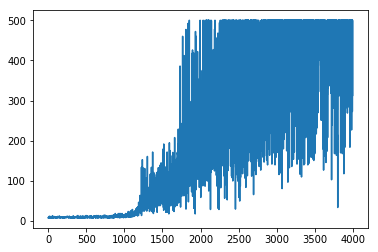

In [10]:
plt.plot(epi_rewards)

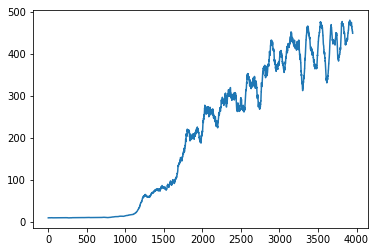

In [11]:
rmoving = running_mean(epi_rewards, 50)
plt.plot(rmoving)

---
## Run your trained agent for a random episode!

---

In [13]:
s = env.reset()
total_reward = 0
while True:
    policy_output = sess.run(softmax_output, feed_dict={S:np.atleast_2d(s)})
    a = np.random.choice(range(len(policy_output.ravel())), p=policy_output.ravel())
    sp, r, d, _ = env.step(a)
        
    env.render()

    total_reward += r
    s = sp
    if d:
        print(total_reward)
        break

500.0
